In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt


In [ ]:
 # !pip install scikit-learn

###Ryen data

In [9]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/header_UNSW-NB15_1.csv')

<ipython-input-9-74054e997c3b>:2: DtypeWarning: Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/header_UNSW-NB15_1.csv')


###Akidul Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# df = pd.read_csv('https://drive.google.com/file/d/1SSK9VHIBEjMDxbjrgm_avkfMTC352Ca1/view?usp=drive_link')

###Latest preprocessing

In [10]:
# Fill NaN values in the target column with a specific label for normal instances
df['Ct_dst_sport_itm.2'] = df['Ct_dst_sport_itm.2'].fillna('Normal')

# Skip columns you want to exclude
columns_to_skip = ['sport', 'dsport', 'Ct_dst_sport_itm.2']  # Replace with the names of columns to skip
df = df.drop(['sport', 'dsport'], axis=1)


In [11]:
# Encoding categorical columns
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns
# Exclude the target column from the list of columns to encode
categorical_columns = [col for col in categorical_columns if col != 'Ct_dst_sport_itm.2']
for col in categorical_columns:
    print(col)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

srcip
dstip
proto
state
Service


In [12]:
# Separate the dataset into normal and attack samples
normal_data = df[df['Ct_dst_sport_itm.2'] == 'Normal']
attack_data = df[df['Ct_dst_sport_itm.2'] != 'Normal']

In [13]:
#########
# Splitting the dataset such that training set contains 80% samples from each class
train_data = pd.DataFrame()
test_data = pd.DataFrame()

unique_classes = attack_data['Ct_dst_sport_itm.2'].unique()

for cls in unique_classes:
    class_data = df[df['Ct_dst_sport_itm.2'] == cls]
    print(cls)
    print(class_data.shape)
    class_train, class_test = train_test_split(class_data, train_size=0.8, random_state=42)
    train_data = pd.concat([train_data, class_train])
    print(f"80 percent number: {train_data.shape}")
    test_data = pd.concat([test_data, class_test])



Exploits
(5409, 47)
80 percent number: (4327, 47)
Reconnaissance
(1759, 47)
80 percent number: (5734, 47)
DoS
(1167, 47)
80 percent number: (6667, 47)
Generic
(7522, 47)
80 percent number: (12684, 47)
Shellcode
(223, 47)
80 percent number: (12862, 47)
 Fuzzers
(5051, 47)
80 percent number: (16902, 47)
Worms
(24, 47)
80 percent number: (16921, 47)
Backdoors
(534, 47)
80 percent number: (17348, 47)
Analysis
(526, 47)
80 percent number: (17768, 47)


In [14]:
# Splitting into X and y
X_train_attack = train_data.drop('Ct_dst_sport_itm.2', axis=1)
y_train_attack = train_data['Ct_dst_sport_itm.2']
X_test_attack = test_data.drop('Ct_dst_sport_itm.2', axis=1)
y_test_attack = test_data['Ct_dst_sport_itm.2']

print('X_train shape:', X_train_attack.shape)
print('y_train shape:', y_train_attack.shape)
print('X_test shape:', X_test_attack.shape)
print('y_test shape:', y_test_attack.shape)

#####

X_train shape: (17768, 46)
y_train shape: (17768,)
X_test shape: (4447, 46)
y_test shape: (4447,)


In [15]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_attack, y_train_attack = smote.fit_resample(X_train_attack, y_train_attack)

In [16]:
# Split the normal samples into training and test sets (80% train, 20% test)
X_normal = normal_data.drop('Ct_dst_sport_itm.2', axis=1)
y_normal = normal_data['Ct_dst_sport_itm.2']
X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split(X_normal, y_normal, train_size=0.8, random_state=42)

In [17]:
# Combine the training and test sets
X_train = pd.concat([X_train_attack, X_train_normal])
y_train = pd.concat([y_train_attack, y_train_normal])
X_test = pd.concat([X_test_attack, X_test_normal])
y_test = pd.concat([y_test_attack, y_test_normal])

In [18]:
# Shuffle the combined training data
X_train = X_train.sample(frac=1, random_state=42).reset_index(drop=True)
y_train = y_train.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
# Binary Classification
y_train_binary = y_train.apply(lambda x: 'Normal' if x == 'Normal' else 'Attack')
y_test_binary = y_test.apply(lambda x: 'Normal' if x == 'Normal' else 'Attack')

####**Binary**

###Decesion Tree

In [20]:
clf_binary_dt = DecisionTreeClassifier()
clf_binary_dt.fit(X_train, y_train_binary)
y_pred_binary_dt = clf_binary_dt.predict(X_test)

In [21]:
print("Binary Classification Report:")
print(classification_report(y_test_binary, y_pred_binary_dt))

Binary Classification Report:
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00      4447
      Normal       1.00      1.00      1.00    135557

    accuracy                           1.00    140004
   macro avg       1.00      1.00      1.00    140004
weighted avg       1.00      1.00      1.00    140004



###Random Forest

In [22]:
clf_binary = RandomForestClassifier(n_estimators=50)
clf_binary.fit(X_train, y_train_binary)
y_pred_binary = clf_binary.predict(X_test)

In [23]:
print("Binary Classification Report random:")
print(classification_report(y_test_binary, y_pred_binary))

Binary Classification Report random:
              precision    recall  f1-score   support

      Attack       1.00      1.00      1.00      4447
      Normal       1.00      1.00      1.00    135557

    accuracy                           1.00    140004
   macro avg       1.00      1.00      1.00    140004
weighted avg       1.00      1.00      1.00    140004



###**Multi Class**

###DecesionTree

In [24]:
# Multi-Class Classification (only on attack samples)
clf_multi_dt = DecisionTreeClassifier()
clf_multi_dt.fit(X_train_attack, y_train_attack)
y_pred_multi_dt = clf_multi_dt.predict(X_test[y_pred_binary_dt == 'Attack'])

###Random

In [25]:
# Multi-Class Classification (only on attack samples)
clf_multi = RandomForestClassifier(n_estimators=50)
clf_multi.fit(X_train_attack, y_train_attack)
y_pred_multi = clf_multi.predict(X_test[y_pred_binary == 'Attack'])

###RF Plot

In [26]:
# Combine predictions
y_pred_final = y_pred_binary.copy()
y_pred_final[y_pred_binary == 'Attack'] = y_pred_multi

In [28]:
print("\nOverall Classification Report:")
report_2 = classification_report(y_test, y_pred_final, output_dict=True)
print(report_2)


Overall Classification Report:
{' Fuzzers': {'precision': 0.8740499457111836, 'recall': 0.7962413452027696, 'f1-score': 0.8333333333333334, 'support': 1011}, 'Analysis': {'precision': 0.08076923076923077, 'recall': 0.19811320754716982, 'f1-score': 0.11475409836065575, 'support': 106}, 'Backdoors': {'precision': 0.03557312252964427, 'recall': 0.08411214953271028, 'f1-score': 0.05, 'support': 107}, 'DoS': {'precision': 0.2342857142857143, 'recall': 0.1752136752136752, 'f1-score': 0.20048899755501226, 'support': 234}, 'Exploits': {'precision': 0.7911522633744856, 'recall': 0.710720887245841, 'f1-score': 0.7487828627069134, 'support': 1082}, 'Generic': {'precision': 0.9964639321074965, 'recall': 0.9362126245847177, 'f1-score': 0.9653991092840015, 'support': 1505}, 'Normal': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 135557}, 'Reconnaissance': {'precision': 0.8506666666666667, 'recall': 0.90625, 'f1-score': 0.8775790921595599, 'support': 352}, 'Shellcode': {'precision': 

In [29]:
f1_scores_RF = {class_name: report_2[class_name]['f1-score'] for class_name in report_2 if class_name not in ['accuracy', 'macro avg', 'weighted avg']}

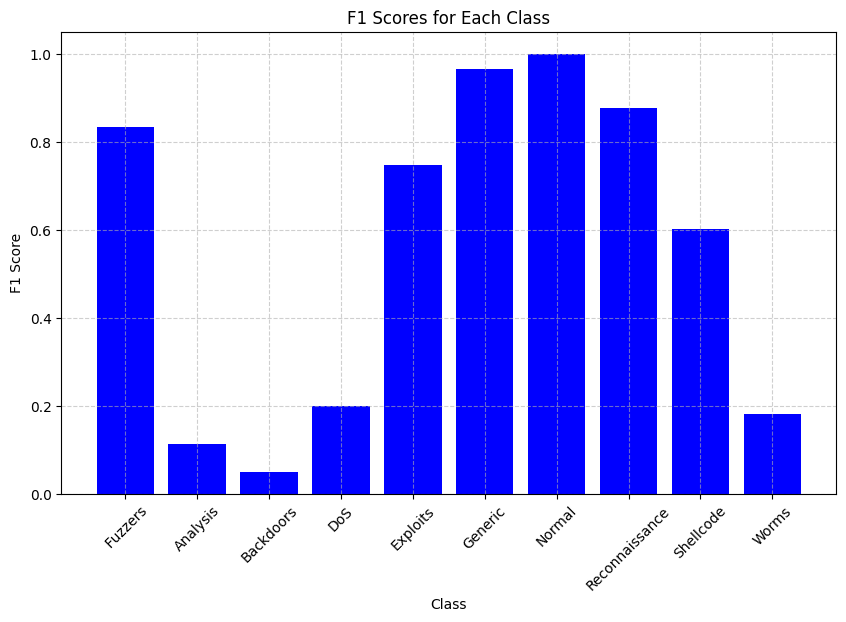

In [30]:
import matplotlib.pyplot as plt

# Assuming f1_scores contains the F1 scores for each class
classes = list(f1_scores_RF.keys())
scores = list(f1_scores_RF.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, scores, color='blue')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Class')
plt.xticks(rotation=45)  # Rotate class labels for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

####DT PLOT###

In [31]:
# Combine predictions
y_pred_final = y_pred_binary_dt.copy()
y_pred_final[y_pred_binary_dt == 'Attack'] = y_pred_multi_dt

In [32]:
print("\nOverall Classification Report:")
report_1 = classification_report(y_test, y_pred_final, output_dict=True)
print(report_1)


Overall Classification Report:
{' Fuzzers': {'precision': 0.8324324324324325, 'recall': 0.76162215628091, 'f1-score': 0.7954545454545455, 'support': 1011}, 'Analysis': {'precision': 0.07368421052631578, 'recall': 0.19811320754716982, 'f1-score': 0.10741687979539641, 'support': 106}, 'Backdoors': {'precision': 0.02608695652173913, 'recall': 0.056074766355140186, 'f1-score': 0.03560830860534125, 'support': 107}, 'DoS': {'precision': 0.16736401673640167, 'recall': 0.17094017094017094, 'f1-score': 0.16913319238900634, 'support': 234}, 'Exploits': {'precision': 0.7748267898383372, 'recall': 0.6201478743068392, 'f1-score': 0.688911704312115, 'support': 1082}, 'Generic': {'precision': 0.9699863574351978, 'recall': 0.9448504983388705, 'f1-score': 0.9572534500168294, 'support': 1505}, 'Normal': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 135557}, 'Reconnaissance': {'precision': 0.8387978142076503, 'recall': 0.8721590909090909, 'f1-score': 0.8551532033426184, 'support': 352}, 

In [33]:
f1_scores_DT = {class_name: report_1[class_name]['f1-score'] for class_name in report_1 if class_name not in ['accuracy', 'macro avg', 'weighted avg']}

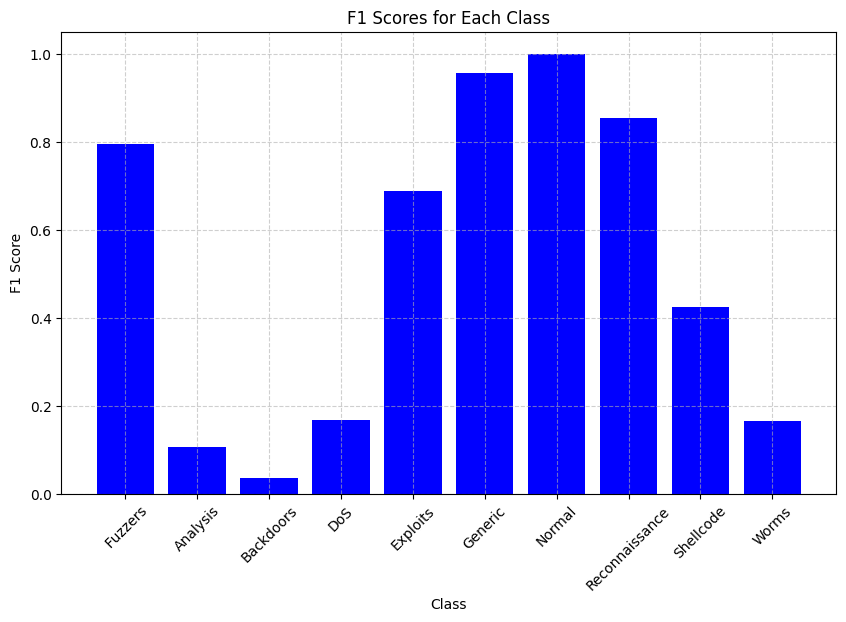

In [34]:
import matplotlib.pyplot as plt

# Assuming f1_scores contains the F1 scores for each class
classes = list(f1_scores_DT.keys())
scores = list(f1_scores_DT.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, scores, color='blue')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Class')
plt.xticks(rotation=45)  # Rotate class labels for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()


**xgboost**


In [35]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [36]:
# Convert binary labels to numeric if they are not already
label_encoder_binary = LabelEncoder()
y_train_binary_encoded = label_encoder_binary.fit_transform(y_train_binary)

# Creating an instance of the XGBoost classifier
clf_binary_xgb = xgb.XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='logloss')

# Fitting the model on the training data
clf_binary_xgb.fit(X_train, y_train_binary_encoded)

# Predicting on the test set
y_pred_binary_dt_encoded = clf_binary_xgb.predict(X_test)
y_pred_binary_XG = label_encoder_binary.inverse_transform(y_pred_binary_dt_encoded)

In [37]:
# Encoding the class labels to integers
label_encoder = LabelEncoder()
y_train_attack_encoded = label_encoder.fit_transform(y_train_attack)

# Creating an instance of the XGBoost classifier
clf_multi_xgb = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')

# Fitting the model on the training data with encoded labels
clf_multi_xgb.fit(X_train_attack, y_train_attack_encoded)

# Predicting on the test set where previous binary predictions were 'Attack'
# Also converting the test labels using the fitted label encoder
y_pred_multi_encoded = clf_multi_xgb.predict(X_test[y_pred_binary == 'Attack'])
y_pred_multi_XG = label_encoder.inverse_transform(y_pred_multi_encoded)


In [38]:
# Combine predictions
y_pred_final = y_pred_binary_XG.copy()
y_pred_final[y_pred_binary_XG == 'Attack'] = y_pred_multi_XG

In [39]:
print("\nOverall Classification Report:")
report_3 = classification_report(y_test, y_pred_final, output_dict=True)
print(report_3)


Overall Classification Report:
{' Fuzzers': {'precision': 0.9260969976905312, 'recall': 0.7932739861523245, 'f1-score': 0.8545551411827385, 'support': 1011}, 'Analysis': {'precision': 0.09006211180124224, 'recall': 0.27358490566037735, 'f1-score': 0.1355140186915888, 'support': 106}, 'Backdoors': {'precision': 0.05944055944055944, 'recall': 0.1588785046728972, 'f1-score': 0.08651399491094146, 'support': 107}, 'DoS': {'precision': 0.2949640287769784, 'recall': 0.1752136752136752, 'f1-score': 0.21983914209115282, 'support': 234}, 'Exploits': {'precision': 0.8130252100840336, 'recall': 0.7153419593345656, 'f1-score': 0.7610619469026548, 'support': 1082}, 'Generic': {'precision': 0.9882189882189882, 'recall': 0.9475083056478405, 'f1-score': 0.9674355495251018, 'support': 1505}, 'Normal': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 135557}, 'Reconnaissance': {'precision': 0.8777777777777778, 'recall': 0.8977272727272727, 'f1-score': 0.8876404494382022, 'support': 352}, 'S

In [40]:
f1_scores_XG = {class_name: report_3[class_name]['f1-score'] for class_name in report_3 if class_name not in ['accuracy', 'macro avg', 'weighted avg']}

Accuracy: 0.77
Classification Report:
                 precision    recall  f1-score   support

       Fuzzers       0.93      0.79      0.85      1011
      Analysis       0.09      0.27      0.14       106
     Backdoors       0.06      0.16      0.09       107
           DoS       0.29      0.18      0.22       234
      Exploits       0.81      0.72      0.76      1082
       Generic       0.99      0.95      0.97      1505
Reconnaissance       0.88      0.90      0.89       352
     Shellcode       0.49      0.78      0.60        45
         Worms       0.25      0.40      0.31         5

      accuracy                           0.77      4447
     macro avg       0.53      0.57      0.54      4447
  weighted avg       0.84      0.77      0.80      4447



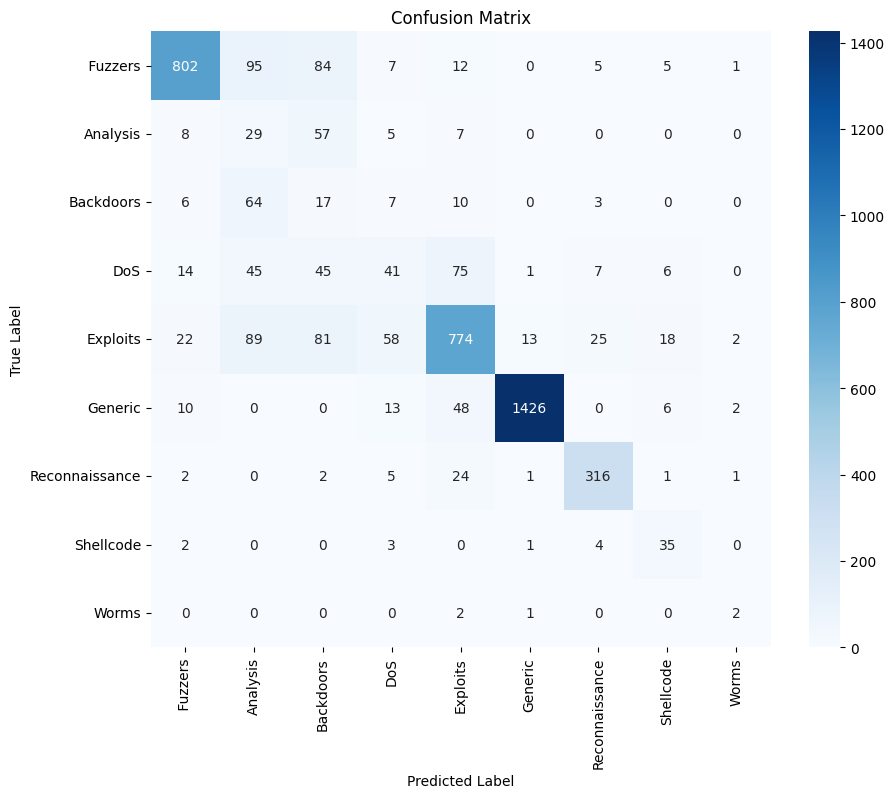

In [41]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test_attack contains the true labels for the test set where binary predictions were 'Attack'
# You need to encode these labels as well
y_test_attack_encoded = label_encoder.transform(y_test[y_pred_binary == 'Attack'])

# Calculate accuracy
accuracy = accuracy_score(y_test_attack_encoded, y_pred_multi_encoded)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
class_report = classification_report(y_test_attack_encoded, y_pred_multi_encoded, target_names=label_encoder.classes_)
print("Classification Report:\n", class_report)

# Generate and plot a confusion matrix
conf_matrix = confusion_matrix(y_test_attack_encoded, y_pred_multi_encoded)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


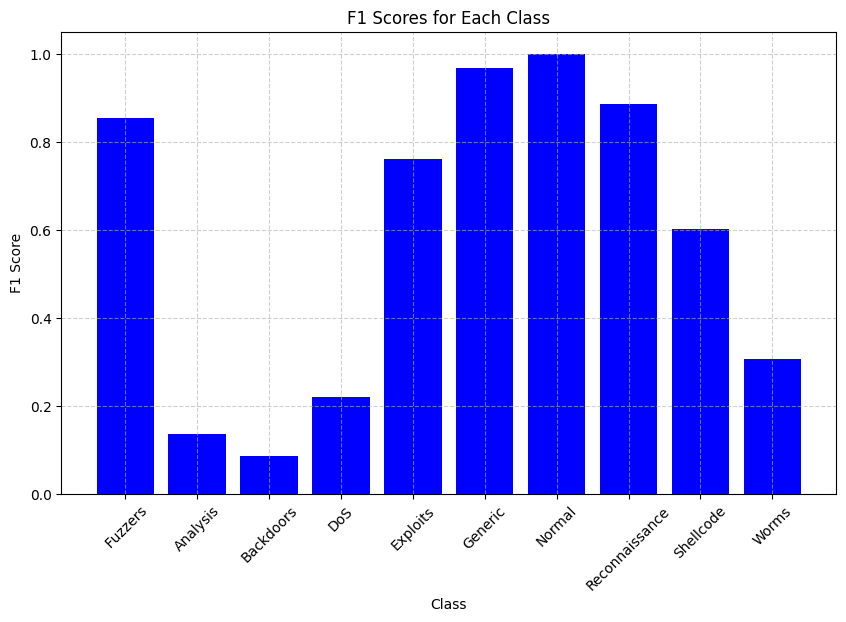

In [42]:
# Assuming f1_scores contains the F1 scores for each class
classes = list(f1_scores_XG.keys())
scores = list(f1_scores_XG.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, scores, color='blue')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Class')
plt.xticks(rotation=45)  # Rotate class labels for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [43]:
conf_matrix_multi = confusion_matrix(y_test[y_pred_binary_XG == 'Attack'], y_pred_multi_XG)
print(conf_matrix_multi)

[[ 802   95   84    7   12    0    5    5    1]
 [   8   29   57    5    7    0    0    0    0]
 [   6   64   17    7   10    0    3    0    0]
 [  14   45   45   41   75    1    7    6    0]
 [  22   89   81   58  774   13   25   18    2]
 [  10    0    0   13   48 1426    0    6    2]
 [   2    0    2    5   24    1  316    1    1]
 [   2    0    0    3    0    1    4   35    0]
 [   0    0    0    0    2    1    0    0    2]]


###Comparisn

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert the dictionaries into a DataFrame
data = {
    'DecisionTree': f1_scores_DT,
    'RandomForest': f1_scores_RF,
    'XGBoost': f1_scores_XG
}
df = pd.DataFrame(data)


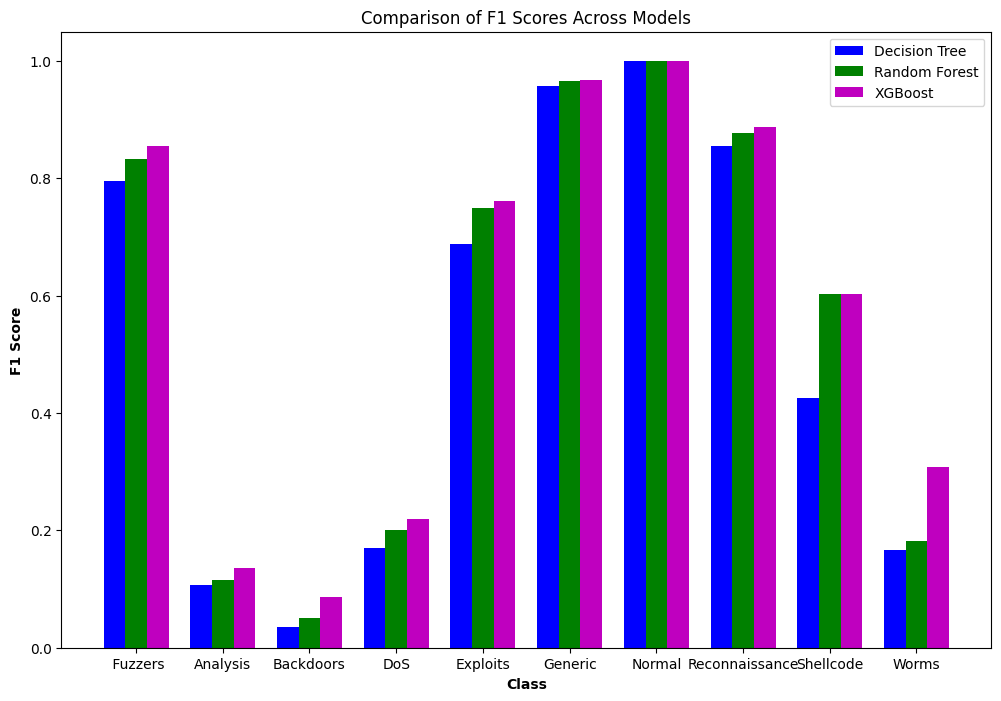

In [45]:
# Set the position of bars on the X axis
r1 = np.arange(len(df))
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]

# Make the plot
plt.figure(figsize=(12, 8))
plt.bar(r1, df['DecisionTree'], color='b', width=0.25, label='Decision Tree')
plt.bar(r2, df['RandomForest'], color='g', width=0.25, label='Random Forest')
plt.bar(r3, df['XGBoost'], color='m', width=0.25, label='XGBoost')

# Add xticks on the middle of the group bars
plt.xlabel('Class', fontweight='bold')
plt.ylabel('F1 Score', fontweight='bold')
plt.xticks([r + 0.25 for r in range(len(df))], df.index)

# Create legend & Show graphic
plt.title('Comparison of F1 Scores Across Models')
plt.legend()
plt.show()

In [46]:
# Save DataFrame to a CSV file
df.to_csv('model_f1_scores.csv', index=False)